In [3]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import gurobi_logtools as glt

Set path with log files

In [17]:
name = "logs\Depth"
PATH = f".\experiments\{name}"

Parse log files

In [18]:
result = glt.parse(PATH+"\*.log")
summary = result.summary()


Get node log

In [19]:

nl = result.progress("nodelog")
nl.head()

c:\Users\sian_\OneDrive\Documents\Thesis\Transformer_Formulation\pyomo_env\lib\site-packages\gurobi_logtools\api.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  left=pd.concat(progress),


,CurrentNode,RemainingNodes,Obj,Depth,IntInf,Incumbent,BestBd,Gap,ItPerNode,Time,NewSolution,LogFilePath,LogNumber,Pruned,Seed,Version
0,0,0.0,85.30778,0.0,771.0,NaN,85.30778,NaN,NaN,0.0,NaN,.\experiments\logs\Depth\depth_vit_E12_D1_6_12...,1,NaN,0,11.0.2
1,0,0.0,85.30778,0.0,772.0,NaN,85.30778,NaN,NaN,0.0,NaN,.\experiments\logs\Depth\depth_vit_E12_D1_6_12...,1,NaN,0,11.0.2
2,0,0.0,85.23011,0.0,739.0,NaN,85.23011,NaN,NaN,0.0,NaN,.\experiments\logs\Depth\depth_vit_E12_D1_6_12...,1,NaN,0,11.0.2
3,0,0.0,85.16092,0.0,738.0,NaN,85.16092,NaN,NaN,0.0,NaN,.\experiments\logs\Depth\depth_vit_E12_D1_6_12...,1,NaN,0,11.0.2
4,0,0.0,85.16032,0.0,738.0,NaN,85.16032,NaN,NaN,0.0,NaN,.\experiments\logs\Depth\depth_vit_E12_D1_6_12...,1,NaN,0,11.0.2


Add columns to node log to indicate experimental set up

In [21]:
regex_pattern = r'.*vit_.*(\d+)_.*(\d+)_(\d+)_(\d+)_i(\d+)_r(\d+)_c(\d+)_.*\.log'
nl[['Embed_Dim', 'Enc_Layers', 'Heads', 'Mlp_Dim', 'I', 'Repetition', 'Config']] = nl['LogFilePath'].str.extract(regex_pattern)
nl.head()


,CurrentNode,RemainingNodes,Obj,Depth,IntInf,Incumbent,BestBd,Gap,ItPerNode,Time,...,Pruned,Seed,Version,Embed_Dim,Enc_Layers,Heads,Mlp_Dim,I,Repetition,Config
0,0,0.0,85.30778,0.0,771.0,NaN,85.30778,NaN,NaN,0.0,...,NaN,0,11.0.2,2,1,6,12,4,1,1
1,0,0.0,85.30778,0.0,772.0,NaN,85.30778,NaN,NaN,0.0,...,NaN,0,11.0.2,2,1,6,12,4,1,1
2,0,0.0,85.23011,0.0,739.0,NaN,85.23011,NaN,NaN,0.0,...,NaN,0,11.0.2,2,1,6,12,4,1,1
3,0,0.0,85.16092,0.0,738.0,NaN,85.16092,NaN,NaN,0.0,...,NaN,0,11.0.2,2,1,6,12,4,1,1
4,0,0.0,85.16032,0.0,738.0,NaN,85.16032,NaN,NaN,0.0,...,NaN,0,11.0.2,2,1,6,12,4,1,1


Aggregate metrics

In [22]:
import pandas as pd
import numpy as np

nl2 = nl
# Ensure columns are numeric, converting non-numeric entries to NaN
for col in ['Time', 'CurrentNode', 'NewSolution', 'Gap', 'Incumbent']:
    nl2[col] = pd.to_numeric(nl[col], errors='coerce')

# Define helper functions for individual column aggregations
def time_to_first_feasible(series):
    feasible_times = series.dropna()
    return feasible_times.min() if not feasible_times.empty else np.nan

def count_feasible(series):
    feasible_times = series.dropna()
    return feasible_times.min() if not feasible_times.empty else np.nan

def final_value(series):
    valid_values = series.dropna()
    return valid_values.iloc[-1] if not valid_values.empty else np.nan

def unique_solutions(series):
    return series.dropna().nunique()

# Aggregate metrics per Embed_Dim, Enc_Layers, and Config
config_metrics = (
    nl2.groupby(['Embed_Dim', 'Enc_Layers', 'Config']).agg(
        Time_to_optimal=('Time', 'max'),
        Nodes_explored=('CurrentNode', 'max'),
        Solutions_found=('Incumbent', unique_solutions),
        Final_gap=('Gap', final_value),
        Objective_value=('Incumbent', final_value)
    )
    .reset_index()
)

# Average the metrics for each unique combination of Embed_Dim, Enc_Layers, and Config
average_metrics = config_metrics.groupby(['Embed_Dim', 'Enc_Layers', 'Config']).mean(numeric_only=True).reset_index()

# Display the resulting DataFrame
average_metrics.columns = [
    'Embed_Dim', 'Enc_Layers', 'Config', 'Avg_Time_to_optimal', 
    'Avg_Nodes_explored', 'Avg_Solutions_found', 'Avg_Final_gap', 'Avg_Objective_value'
]

average_metrics


,Embed_Dim,Enc_Layers,Config,Avg_Time_to_optimal,Avg_Nodes_explored,Avg_Solutions_found,Avg_Final_gap,Avg_Objective_value
0,2,1,1,54.70,24316.0,3.0,0.000099,-15.710727
1,2,2,1,1399.99,2804.0,5.0,0.000052,-9.522120
2,2,2,4,1391.39,12693.0,3.0,0.000099,-9.522762
3,6,1,1,14.26,7018.0,3.0,0.000098,-12.498411
4,6,1,4,9.78,2657.0,2.0,0.000068,-12.498411
5,6,2,1,43200.08,10647833.0,0.0,NaN,NaN
6,6,2,4,43200.02,8691385.0,0.0,NaN,NaN


Get groupings of unique combinations of embedding size, encoder layers and configuration

In [29]:
configs = grouped_nl[['Embed_Dim', 'Enc_Layers', 'Config']].drop_duplicates().values
configs

array([['2', '1', '1'],
       ['2', '2', '1'],
       ['2', '2', '4'],
       ['6', '1', '1'],
       ['6', '1', '4'],
       ['6', '2', '1'],
       ['6', '2', '4']], dtype=object)

Name groupings

In [31]:
conf = ['No_MC','I_only', 'LN_prop', 'ALL']
combinations = {}
for i in configs:
        print(i, conf)
        combinations[f'E{i[0]}_D{i[1]}_{conf[int(i[-1])-1]}'] = i[0]+i[-1]
    
print(combinations)

['2' '1' '1'] ['No_MC', 'I_only', 'LN_prop', 'ALL']
['2' '2' '1'] ['No_MC', 'I_only', 'LN_prop', 'ALL']
['2' '2' '4'] ['No_MC', 'I_only', 'LN_prop', 'ALL']
['6' '1' '1'] ['No_MC', 'I_only', 'LN_prop', 'ALL']
['6' '1' '4'] ['No_MC', 'I_only', 'LN_prop', 'ALL']
['6' '2' '1'] ['No_MC', 'I_only', 'LN_prop', 'ALL']
['6' '2' '4'] ['No_MC', 'I_only', 'LN_prop', 'ALL']
{'E2_D1_No_MC': '21', 'E2_D2_No_MC': '21', 'E2_D2_ALL': '24', 'E6_D1_No_MC': '61', 'E6_D1_ALL': '64', 'E6_D2_No_MC': '61', 'E6_D2_ALL': '64'}


Plot convergence of bounds on objective value

C:\Users\sian_\AppData\Local\Temp\ipykernel_123316\3359421362.py:22: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-x" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(config_data['Time'], config_data['Incumbent_mean'],'-x',linestyle='-', label=f'{config_names[i]} - Incumbent', color=color)
C:\Users\sian_\AppData\Local\Temp\ipykernel_123316\3359421362.py:25: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 49000)


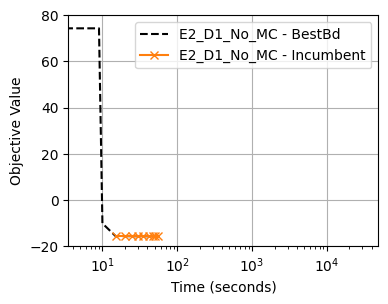

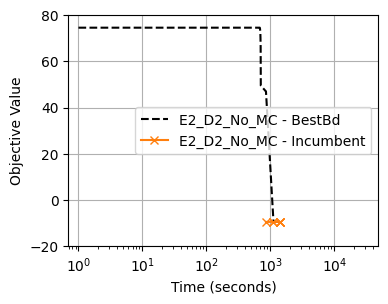

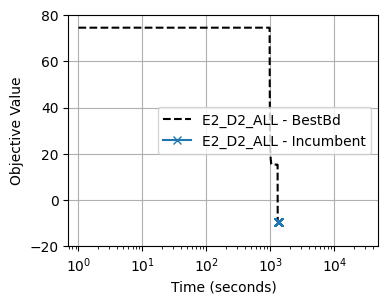

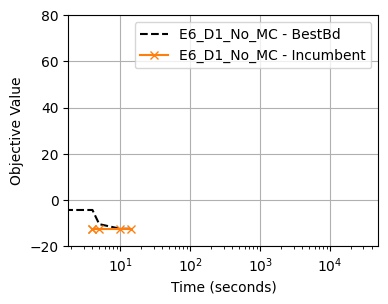

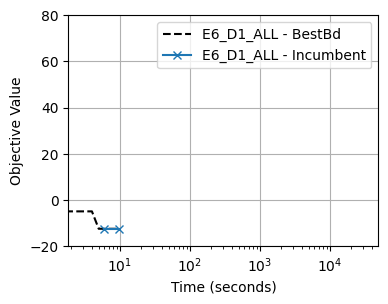

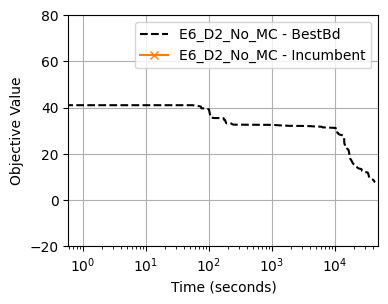

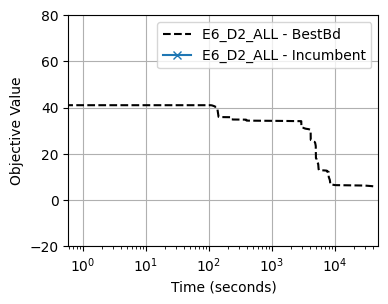

In [33]:
import matplotlib.pyplot as plt

# Initialize the figure size
colors = plt.get_cmap('tab10', len(grouped_nl['Config'].unique()))
config_names = list(combinations.keys())
colours = ['tab:orange', 'tab:red', 'tab:olive', 'tab:blue']


# Plot each configuration using the same x and y axis limits
for i, config in enumerate(configs):
    plt.figure(i, figsize=(4, 3))
    config_data = grouped_nl[(grouped_nl['Embed_Dim'] == config[0]) & (grouped_nl['Enc_Layers'] == config[1]) & (grouped_nl['Config'] == config[-1])]
    color = colours[int(config[-1])-1]
    # plt.yscale('log')
    plt.xscale('log')
    

    # Plot BestBd mean
    plt.plot(config_data['Time'], config_data['BestBd_mean'], linestyle='--', label=f'{config_names[i]} - BestBd', color='k')
    
    # Plot Incumbent mean
    plt.plot(config_data['Time'], config_data['Incumbent_mean'],'-x',linestyle='-', label=f'{config_names[i]} - Incumbent', color=color)

    # # Set the same x and y limits for all plots
    plt.xlim(0, 49000)
    plt.ylim(-20, 80)
    
    

    # Add labels
    plt.grid(True)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Objective Value')
    plt.legend()
     
